In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
%matplotlib inline
import tensorflow as tf
import keras
import glob
import cv2
import pickle, datetime

from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D,GlobalAveragePooling2D
from keras.layers import LSTM, Input, TimeDistributed,Convolution2D,Activation
from keras.layers.convolutional import ZeroPadding2D
from keras.optimizers import RMSprop, SGD
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras import optimizers
from keras.preprocessing import sequence
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import load_model

from sklearn.preprocessing import LabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
# Import the backend
from keras import backend as K
K.tensorflow_backend._get_available_gpus()
import os

Using TensorFlow backend.


In [2]:
print(os.listdir("C://Users//Mithun//Documents//Project Dhwani CNNRF//ImageModels-master//ImageModels-master//Example"))

['Trainexample', 'Trainexample1', 'Validation-Example', 'Validation-Example1']


### Read the train & test Images and preprocessing

In [3]:
train_fruit_images = []
train_fruit_labels = [] 
for directory_path in glob.glob("Example/Trainexample1/*"):
    fruit_label = directory_path.split("\\")[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
        img = cv2.resize(img, (227, 227))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        train_fruit_images.append(img)
        train_fruit_labels.append(fruit_label)
train_fruit_images = np.array(train_fruit_images)
train_fruit_labels = np.array(train_fruit_labels)

In [4]:
label_to_id = {v:i for i,v in enumerate(np.unique(train_fruit_labels))}
id_to_label = {v: k for k, v in label_to_id.items()}
train_label_ids = np.array([label_to_id[x] for x in train_fruit_labels])



In [5]:
train_fruit_images.shape, train_label_ids.shape, train_fruit_labels.shape

((2637, 227, 227, 3), (2637,), (2637,))

In [6]:
# test
test_fruit_images = []
test_fruit_labels = [] 
for directory_path in glob.glob("Example/Validation-Example1/*"):
    fruit_label = directory_path.split("\\")[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        
        img = cv2.resize(img, (227, 227))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        
        test_fruit_images.append(img)
        test_fruit_labels.append(fruit_label)
test_fruit_images = np.array(test_fruit_images)
test_fruit_labels = np.array(test_fruit_labels)

In [7]:
test_label_ids = np.array([label_to_id[x] for x in test_fruit_labels])

In [8]:
test_fruit_images.shape, test_label_ids.shape

((885, 227, 227, 3), (885,))

In [9]:
x_train, y_train, x_test, y_test, N_CATEGORY =train_fruit_images,train_fruit_labels,test_fruit_images,test_fruit_labels,len(label_to_id)

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape, N_CATEGORY)

(2637, 227, 227, 3) (2637,) (885, 227, 227, 3) (885,) 6


### Classes with its ids

In [163]:
id_to_label

{0: 'Apple Golden 1',
 1: 'Avocado',
 2: 'Banana',
 3: 'Lemon',
 4: 'Pineapple',
 5: 'Strawberry'}

### Creation of AlexNet structure of CNN

In [13]:
alexnet = get_alexnet((227,227,3),N_CATEGORY)
alexnet.summary()

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(96, (11, 11), input_shape=(227, 227,..., padding="same")`
  


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 227, 227, 96)      34944     
_________________________________________________________________
activation_1 (Activation)    (None, 227, 227, 96)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 113, 113, 96)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 113, 113, 128)     307328    
_________________________________________________________________
activation_2 (Activation)    (None, 113, 113, 128)     0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 58, 58, 128)       0         
__________

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (5, 5), padding="same")`
  # This is added back by InteractiveShellApp.init_path()
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(384, (3, 3), padding="same")`
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(192, (3, 3), padding="same")`
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), padding="same")`
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:33: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4096, kernel_initializer="glorot_normal")`
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:38: UserWarning: Update your `

In [16]:
#Normalization of the images and one-hot encoding of the labels
alexnet.compile(loss='categorical_crossentropy', optimizer=RMSprop(),metrics=['accuracy'])
X_normalized = np.array(x_train / 255.0 - 0.5 )
X_normalized_test = np.array(x_test / 255.0 - 0.5 )

label_binarizer = LabelBinarizer()
y_one_hot = label_binarizer.fit_transform(y_train)
y_one_hot_test = label_binarizer.fit_transform(y_test)

In [17]:
#Training the AlexNet model with the normalized image data and labels
alexnet.fit(X_normalized, y_one_hot, batch_size=5, epochs=2,verbose=1, validation_data=[X_normalized_test,y_one_hot_test])

Train on 2637 samples, validate on 885 samples
Epoch 1/2
2637/2637 [==============================] - 734s 278ms/step - loss: 3.7883 - acc: 0.1866 - val_loss: 3.7667 - val_acc: 0.1853
Epoch 2/2
2637/2637 [==============================] - 714s 271ms/step - loss: 3.7718 - acc: 0.1866 - val_loss: 3.7667 - val_acc: 0.1853


#### Result of the Alexnet
The accuracy of the whole AlexNet model is 0.1866 which is 18.66%.

Here, the classification is performed by the other Fully-connected layer and Softmax function.


In [21]:
#Save the AlexNet model for the future use(as it takes hours to be trained!)
alexnet.save('alexnetfruit.h5') 

### Feature Extraction by CNN

In [67]:
#Pick the first Fully-Connected layer as the features which will be of dimension (1 x 4096)
layer_name = 'dense_1'
FC_layer_model = Model(inputs=alexnet.input,
                                 outputs=alexnet.get_layer(layer_name).output)

In [89]:
#Find the Features for n number of train images and we will get n x 4096
#This means we will get 4096 features for each images.
i=0
features=np.zeros(shape=(x_train.shape[0],4096))
for directory_path in glob.glob("Example/Trainexample1/*"):
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)    
        img = cv2.resize(img, (227, 227))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        img = np.expand_dims(img, axis=0)
        FC_output = FC_layer_model.predict(img)
        features[i]=FC_output
        i+=1


In [92]:
#Save the features of the train images to use it in future.
np.save('features', features)

In [ ]:
#Name the feature rows as f_0, f_1, f_2...
feature_col=[]
for i in range(4096):
    feature_col.append("f_"+str(i))
    i+=1
    

In [147]:
#Create DataFrame with features and coloumn name
train_features=pd.DataFrame(data=features,columns=feature_col)
feature_col = np.array(feature_col)

train_class = list(np.unique(train_label_ids))
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_label_ids.shape)
train_class

Training Features Shape: (2637, 4096)
Training Labels Shape: (2637,)


[0, 1, 2, 3, 4, 5]

### Random Forest as Classifier

In [152]:
#Feed the extracted features with the labels to RANDOM FOREST 
rf = RandomForestClassifier(n_estimators = 20, random_state = 42,max_features=4)

rf.fit(train_features, train_label_ids)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=4, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

### Testing the Novel Algorithm

#### Feature Extraction by CNN (AlexNet)

In [118]:
#Find the Features from Alexnet's FC layer for n number of test images and we will get n x 4096
i=0
features_test=np.zeros(shape=(y_test.shape[0],4096))
for directory_path in glob.glob("Example/Validation-Example1//*"):
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)    
        img = cv2.resize(img, (227, 227))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        img = np.expand_dims(img, axis=0)
        FC_output = FC_layer_model.predict(img)
        features_test[i]=FC_output
        i+=1


In [137]:
#Create DataFrame with features and coloumn name
test_features=pd.DataFrame(data=features_test,columns=feature_col)
feature_col = np.array(feature_col)

print('Test Features Shape:', test_features.shape)
print('Test Labels Shape:', test_label_ids.shape)


Test Features Shape: (885, 4096)
Test Labels Shape: (885,)


#### Classification by Random Forest

In [153]:
#Feed the features of the test images to Random Forest Classifier to predict its class
predictions = rf.predict(test_features)

### Checking the Accuracy of the Novel Model

In [161]:
accuracy=accuracy_score(predictions , test_label_ids)
print('Accuracy:', accuracy*100, '%.')

Accuracy: 85.8757062147 %.


### Comparision of CNN vs CNN+RF

- Accuracy of CNN: 18.66%
- Accuracy of CNN+RF: 85.88%

From the results above it is crystal clear that merging Random Forest with the CNN gives almost 5 times better accuracy.

## Let's have some fun!!

Give the path of any fruit image in img_path and Voila!!

It's Banana


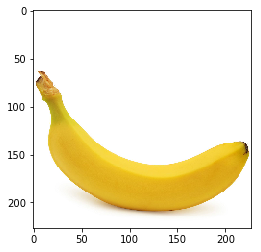

In [184]:

img_path="C://Users//Documents//Project Dhwani CNNRF//ImageModels-master//ImageModels-master//banana.jpg"
img = cv2.imread(img_path, cv2.IMREAD_COLOR)
img = cv2.resize(img, (227, 227))
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
plt.imshow(img)
img = np.expand_dims(img, axis=0)
FC_output = FC_layer_model.predict(img)
image_features=pd.DataFrame(data=FC_output,columns=feature_col)
predictions = rf.predict(image_features)
print("It's",id_to_label[predictions[0]])

## References:

- http://euler.stat.yale.edu/~tba3/stat665/lectures/lec18/notebook18.html
- http://cs231n.github.io/convolutional-networks/
- http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html